<a href="https://colab.research.google.com/github/anorexbill/CIFAR10-Image-Classification-Deep-Learning/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02 - CIFAR10 Image Classification

In this assignment your team will design a fully connected neural network and a convolutional neural network (CNN) models for classifiying the CIFAR10 image dataset. The deliverables for the assignment are:

1. This jupyter-notebook completed with your solution. I expect you to try different configurations (models, train/validtion split, etc.), but for your submission, leave just the best fully connected and the best CNN models.
    - Name the notebook as enel645_assignment02_team_(team number).ipynb
2. The weights of your best fully connected neural network model and your best CNN model 
    - Name the weights files as team_(team number)_FCN.h5 (fully connected model) and team_(team number)_FCN.h5 (CNN model)

Submit the three files (notebook + models' weights) to your dropbox in the course D2L page.
    
We will be using the CIFAR10 dataset. The dataset alerady comes with a test set and you shouldn't change it. It is up to you to determine how to split your development set into training and validation sets. Use variable names consistent with the variables pre-filled in this document.


You are free to add extra cells of text and code to this notebook.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final 
grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on:

1. Code execution - 20% 
2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%


In [39]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

## 1. Load your data

In [40]:
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

print(X_dev.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


## 2. Explore your data 

In [41]:
print(f"The shape of the Training and validation dataset is {X_dev.shape}")
print(f"The shape of the Training and validation labels is {Y_dev.shape}")
print(f"The shape of the test dataset is {X_test.shape}")
print(f"The shape of the test labels is {Y_test.shape}")

The shape of the Training and validation dataset is (50000, 32, 32, 3)
The shape of the Training and validation labels is (50000, 1)
The shape of the test dataset is (10000, 32, 32, 3)
The shape of the test labels is (10000, 1)


In [42]:
print(f"the number of classes is {np.unique(Y_dev).size}")

the number of classes is 10


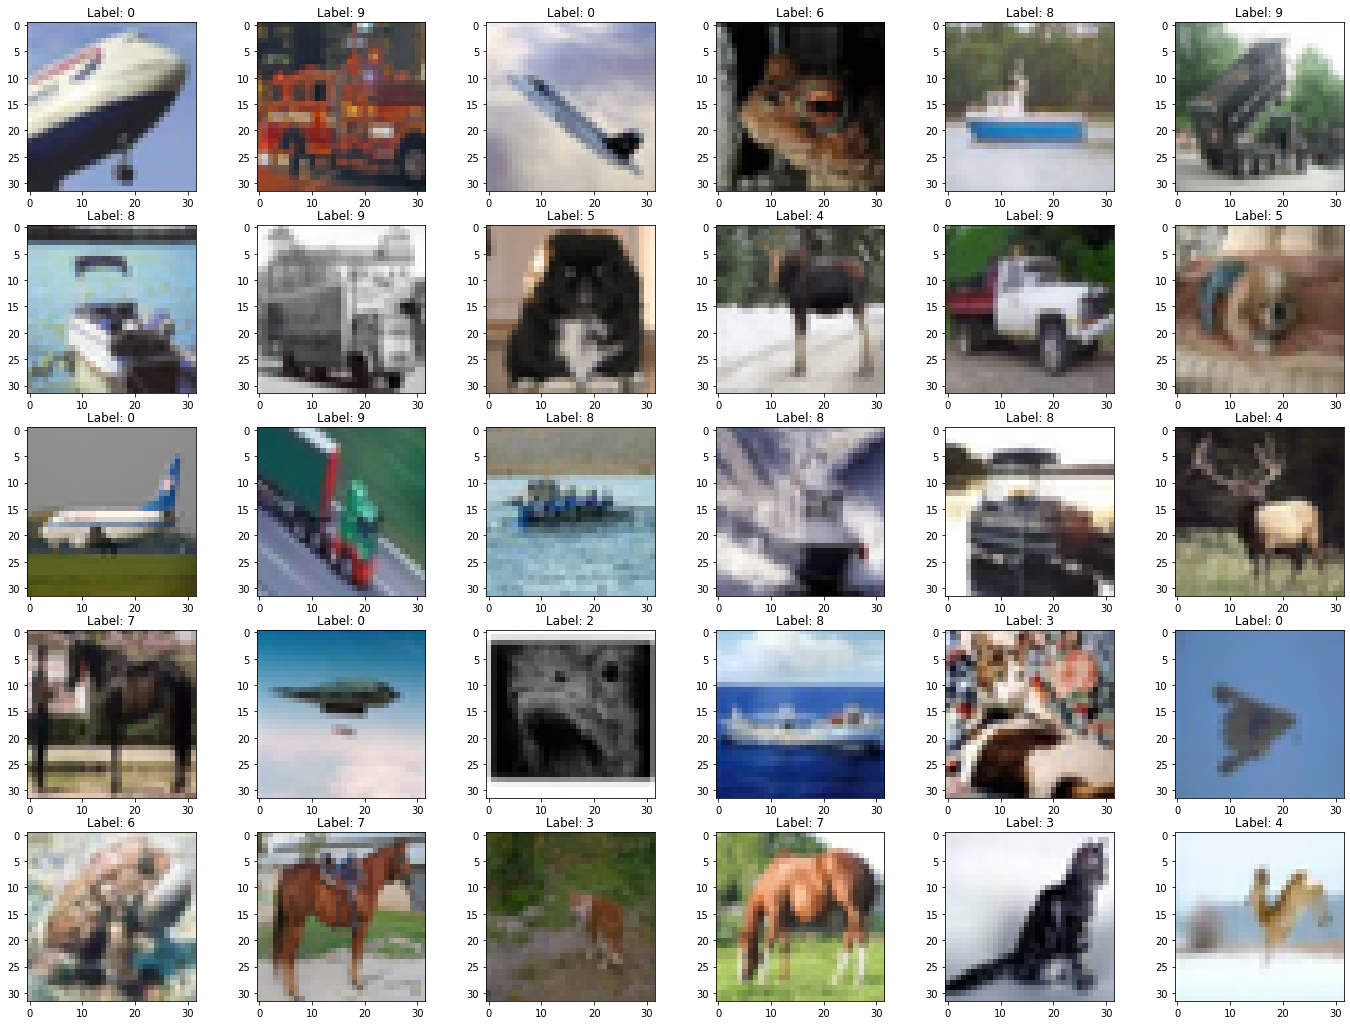

In [43]:
#Displaying some samples from the dataset
sample_indexes = np.random.choice(np.arange(X_dev.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_dev[jj], cmap = "gray")
    plt.title("Label: %d" %Y_dev[jj])
plt.show()

In [44]:
#Spliting the dev dataset into training and validation sets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_dev, Y_dev = shuffle(X_dev, Y_dev)

X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size = 0.25, random_state = 1)

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)


Train set
Images:  (37500, 32, 32, 3)
Labels shape:  (37500, 1)

Validation set
Images:  (12500, 32, 32, 3)
Labels shape:  (12500, 1)


In [45]:
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

0 255 120.60254322916667 64.11147511440114
0 255 121.02263080729166 64.26470935228001


## 3. Represent your labels using one hot encoding

In [46]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)

## 4. Data scaling and Data augmentation

In [47]:
norm_type = 0 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass

In [48]:
train_datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, 
                             shear_range=0.15, zoom_range=0.1, channel_shift_range=10, 
                             horizontal_flip=True, vertical_flip=True)

val_datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, 
                             shear_range=0.15, zoom_range=0.1, channel_shift_range=10, 
                             horizontal_flip=True, vertical_flip=True)

train_datagen.fit(X_train)
val_datagen.fit(X_val)

train_dataflow = train_datagen.flow(X_train,Y_train_oh,batch_size = 32)
val_dataflow = val_datagen.flow(X_val,Y_val_oh,batch_size = 32)

## Fully Connected Model

## 5. Define your  model, cost function, optimizer, learning rate

In [55]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_fully_connected(ishape=(32, 32, 3), k= 10, lr=1e-4, drop=0.2):
  model_input = tf.keras.layers.Input(shape=ishape)
  model_input_flattened = tf.keras.layers.Flatten()(model_input)
  model_layer1 = tf.keras.layers.Dense(256, activation="relu")(model_input_flattened)
  model_drop = tf.keras.layers.Dropout(rate=drop)(model_layer1)
  output = tf.keras.layers.Dense(k, activation = 'softmax')(model_drop)
  model = tf.keras.models.Model(inputs=model_input, outputs= output)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
  return model

In [56]:
model = my_model_fully_connected()
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               786688    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 789,258
Trainable params: 789,258
Non-trainable params: 0
_________________________________________________________________


## 6. Define your callbacks (save your model, patience, etc.)

In [57]:
model_name_fcn = "team_(team number)_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_fcn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%6 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 7. Train your model

In [58]:
model.fit(X_train, Y_train_oh, batch_size = 32, epochs = 1000, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule], validation_data=(X_val,Y_val_oh))

Epoch 1/1000
1172/1172 [==============================] - 9s 8ms/step - loss: 2.0395 - accuracy: 0.2604 - val_loss: 1.8381 - val_accuracy: 0.3461
Epoch 2/1000
1172/1172 [==============================] - 9s 7ms/step - loss: 1.8046 - accuracy: 0.3559 - val_loss: 1.7186 - val_accuracy: 0.3936
Epoch 3/1000
1172/1172 [==============================] - 9s 7ms/step - loss: 1.7357 - accuracy: 0.3850 - val_loss: 1.6733 - val_accuracy: 0.4154
Epoch 4/1000
1172/1172 [==============================] - 8s 7ms/step - loss: 1.6794 - accuracy: 0.4032 - val_loss: 1.6358 - val_accuracy: 0.4356
Epoch 5/1000
1172/1172 [==============================] - 9s 8ms/step - loss: 1.6445 - accuracy: 0.4191 - val_loss: 1.6018 - val_accuracy: 0.4446
Epoch 6/1000
1172/1172 [==============================] - 8s 7ms/step - loss: 1.6088 - accuracy: 0.4346 - val_loss: 1.5984 - val_accuracy: 0.4438
Epoch 7/1000
1172/1172 [==============================] - 8s 7ms/step - loss: 1.5707 - accuracy: 0.4464 - val_loss: 1.5441 -

In [59]:
# model.fit(datagen.flow(X_train, Y_train, batch_size=32),
#           steps_per_epoch=len(X_train) / 32, epochs=1000)

## 8. Test your model

313/313 [==============================] - 1s 2ms/step - loss: 1.4401 - accuracy: 0.4957
5043


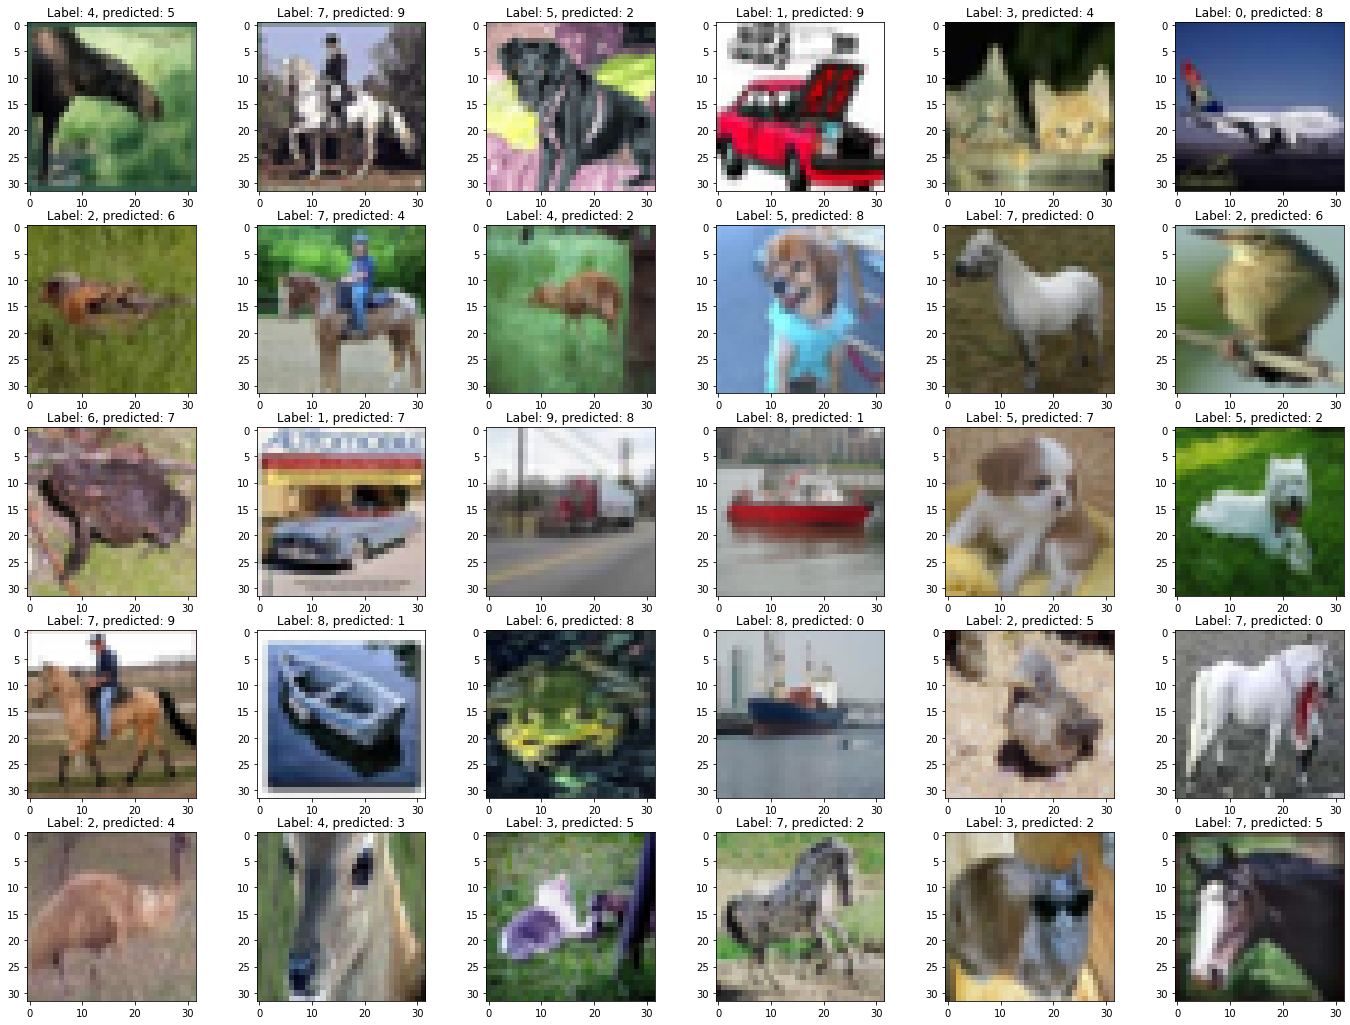

In [60]:
model.load_weights(model_name_fcn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test[:,0])[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

## Convolutional Model

## 5. Define your  model, cost function, optimizer, learning rate

In [69]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_cnn(ishape = (32, 32, 3), k = 10, lr = 1e-4, drop=0.2):
  input_model = tf.keras.layers.Input(shape = ishape)
  layer1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu")(input_model)
  layer2 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu")(layer1)  
  max_layer1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(layer2)
  layer3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu")(max_layer1)
  layer4 = tf.keras.layers.Conv2D(filters =  64, kernel_size = (3, 3), activation =  "relu")(layer3) 
  max_layer2 = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(layer4)
  flatten = tf.keras.layers.Flatten()(max_layer2)
  model_drop = tf.keras.layers.Dropout(rate=drop)(flatten)
  output = tf.keras.layers.Dense(units= 10, activation= "softmax")(model_drop)
  model = tf.keras.models.Model(inputs= input_model, outputs= output)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
  return model

In [70]:
model = my_model_cnn()
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0   

## 6. Define your callbacks (save your model, patience, etc.)

In [71]:
model_name_cnn = "team_(team number)_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_cnn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 7. Train your model

In [72]:
model.fit(X_train,Y_train_oh,batch_size = 32, epochs = 1000, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,Y_val_oh))

Epoch 1/1000
1172/1172 [==============================] - 127s 108ms/step - loss: 2.1532 - accuracy: 0.1990 - val_loss: 1.7580 - val_accuracy: 0.3735
Epoch 2/1000
1172/1172 [==============================] - 125s 107ms/step - loss: 1.7365 - accuracy: 0.3702 - val_loss: 1.6347 - val_accuracy: 0.4162
Epoch 3/1000
1172/1172 [==============================] - 126s 107ms/step - loss: 1.6128 - accuracy: 0.4076 - val_loss: 1.5266 - val_accuracy: 0.4477
Epoch 4/1000
1172/1172 [==============================] - 126s 107ms/step - loss: 1.5347 - accuracy: 0.4369 - val_loss: 1.4587 - val_accuracy: 0.4794
Epoch 5/1000
1172/1172 [==============================] - 125s 107ms/step - loss: 1.4812 - accuracy: 0.4619 - val_loss: 1.4176 - val_accuracy: 0.4990
Epoch 6/1000
1172/1172 [==============================] - 125s 107ms/step - loss: 1.4333 - accuracy: 0.4781 - val_loss: 1.3885 - val_accuracy: 0.5097
Epoch 7/1000
1172/1172 [==============================] - 125s 107ms/step - loss: 1.4021 - accuracy:

## 8. Test your model

313/313 [==============================] - 8s 24ms/step - loss: 1.1096 - accuracy: 0.6121
3879


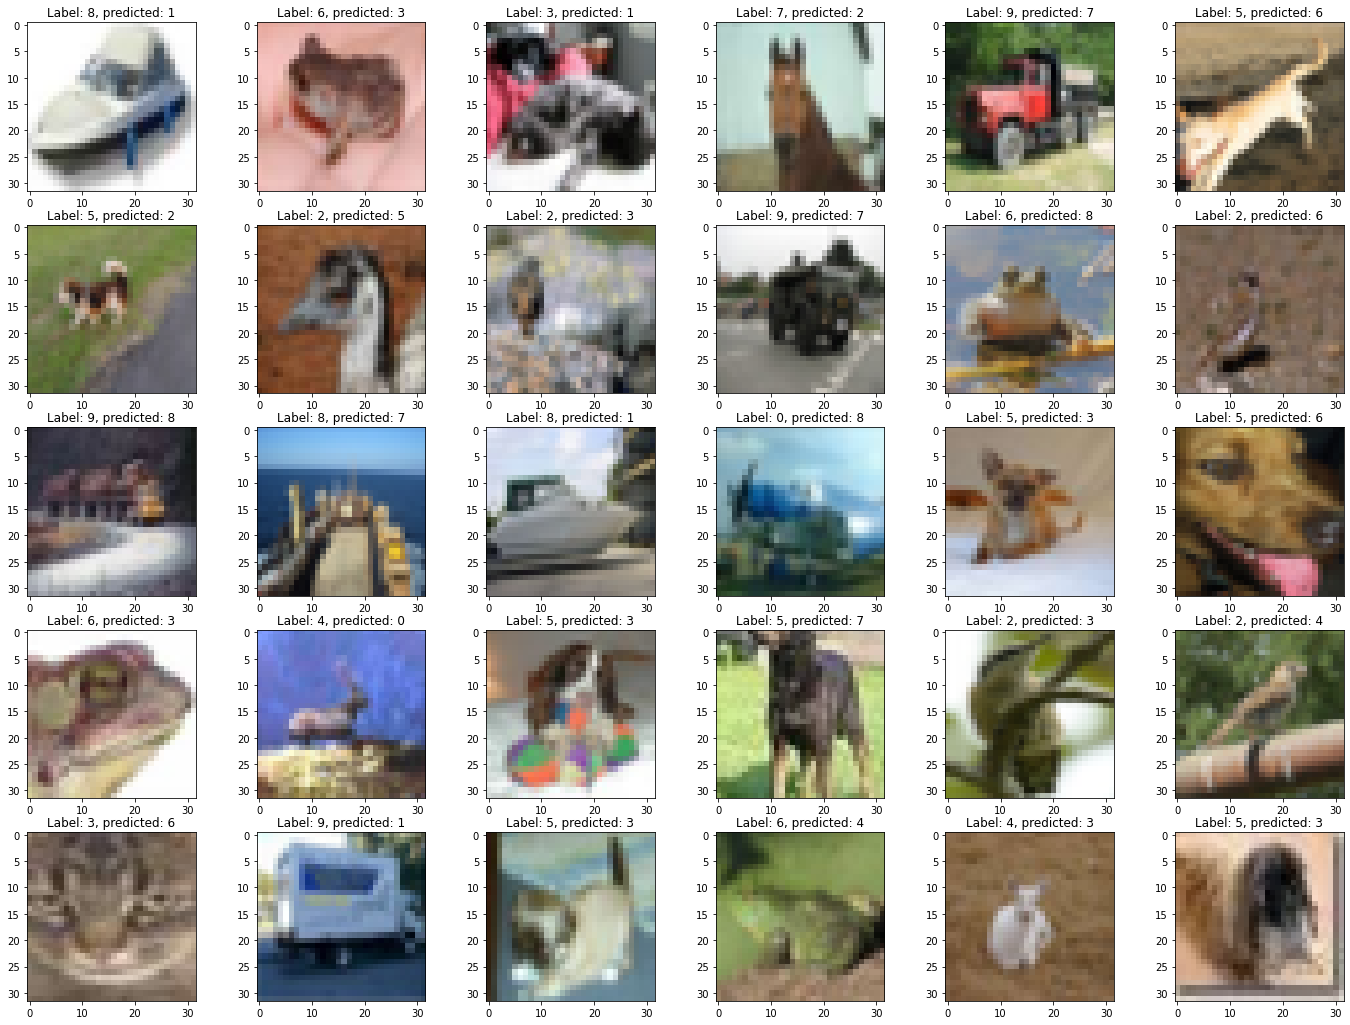

In [73]:
model.load_weights(model_name_cnn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test[:,0])[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()